# Hip Hop Popularity
### *Building a predictive model*

## Summary
In this project, I sought to build a tool that could help my cousin, a hip hop artist, to 

## Context
Audio classification is a classic use case for neural network models. In a previous project, for example, we built a classifier to distinguish between music genres from [this dataset](http://marsyas.info/downloads/datasets.html). This has been done in multiple blog posts ([blog 1,](https://medium.com/swlh/music-genre-classification-using-transfer-learning-pytorch-ea1c23e36eb8) [blog 2](https://www.analyticsvidhya.com/blog/2021/06/music-genres-classification-using-deep-learning-techniques/)) and would seem to be a fairly well-known project. In addition, there are audio classification competitions going right now on Kaggle that would be prime candidates for a similar kind of workflow. [This speech recognition competition from Google Brain](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge) and [this bird call identification competition from Cornell Lab of Ornithology](https://www.kaggle.com/c/birdsong-recognition) are two big examples.

With these in mind, I wondered how far I could take audio classification. Genres, human speech, and bird calls involve classes whose differences are plain to the human ear. Jazz sounds different than metal, syllables sound different from one another, and different birds have different calls. These are all obvious to a human observer. I knew that machines have a higher capacity for differentiation than humans have, and I found it peculiar that in the realm of audio, that we gave machines problems that the human ear could solve effortlessly. The most difficult audio example I could find was [differentiating COVID-19 coughs from normal coughs,](https://www.kaggle.com/andrewmvd/covid19-cough-audio-classification) but a trained respiratory doctor could probably assess decently well. In comparison, we have models that can predict whether [water wells in Tanzania are functional or not](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/) based on a slew of datapoints about the well. In the field of neural networks, [Nature published a deep neural network that can look at an ecg to make predictions about a heart diagnosis.](https://www.nature.com/articles/s41467-020-15432-4)  A human would have significant difficulty sifting through either data set to make such predictions (except maybe a cardiologist for the second one).

Therefore, I wanted to choose a project that involved audio to make a prediction on something that a human would have difficulty doing. I wanted to push the envelope and do something ambitious. I love music, so I wanted to see if a model trained only on song samples could predict a track's popularity. This is a pretty common idea ([blog 1,](https://towardsdatascience.com/predicting-popularity-on-spotify-when-data-needs-culture-more-than-culture-needs-data-2ed3661f75f1#:~:text=According%20to%20Spotify%2C%20%E2%80%9Cpopularity%20is,a%20lot%20in%20the%20past.%E2%80%9D) [blog 2,](https://towardsdatascience.com/predicting-spotify-song-popularity-49d000f254c7) [blog 3](https://medium.com/m2mtechconnect/predicting-spotify-song-popularity-with-machine-learning-7a51d985359b)), but these all use Spotify's provided audio features (such as danceability, instrumentalness, and others). They don't use the audio samples themselves, and I thought that using the raw song samples witha neural net might work out better. Popularity is a tough target--the above blog posts have mixed success with more traditional (i.e. not neural network) techniques. Furthermore, a person can't listen to a song and say "oh yeah, that *sounds* popular". They might say that it sounds *good* but popularity is a bit more nebulous to quantify. Thus, if neural networks are typically used with audio data that is relatively easy for the human ear to classify, this might be a tough project that doesn't work out to make a useful tool in the end.

I had faith though. A properly trained neural network is a powerful thing, and if it didn't work out in the end, I might have answered a different but similarly interesting question about the limits of data science in audio neural networks.

## Business Problem
KC Makes Music is the stage name for my cousin, who is a hip hop artist on spotify. I thought it would make for an interesting learning experience if I used my data science skills to try and help him gain listeners on the platform. He has had some success, with ~24.5k monthly listners as of Dec. 2021, but understanding what to do to gain monthly listeners and gain a following tends towards the arcane. Spotify has an extremely robust database, so I knew there was an opportunity here to help my cousin increase his listener base, and therefore expand his reach as an artist.

After looking at the available angles for this project, I decided that one way to go about this was to survey recent hop hop tracks and try to build a model that could predict if a previously unreleased song had potential to be popular in the current scene. I would gather a random assortment of songs (of all popularity scores), take their preview audio files, transform them into spectrograms, and then feed them through a neural network. This would, hopefully, provide a model that has picked up on common features among the popular songs such that it could tell if a new song would be popular. My cousin has a number of unreleased, finished tracks which we could put through the model. If it's accurate enough, it could determine which of the tracks would do well. If none of them do well, it would signal to my cousin that his tracks could use more work, and we could re-test them in an iterative manner. Furthermore, I could use tools like LIME to determine what in particular the model is finding important and pass that information along to my cousin, to focus on.

In this project, it is most important that the model can separate between the two classes. Having a model that mixes up popular and unpopular songs is useless. A false positive means that my cousin releases a song that won't do well, and a false negative means that my cousin overproduces a song that is good as it was. Either way, we ruin good work. With this in mind, accuracy is a useful metric, but ROC-AUC is the preferred metric to use, as it measures how well the two classes can be separated.

## Data Understanding
All data comes from Spotify. Spotify was chosen because not only is it the platform we are trying to optimize for, but also because it is one of the most comprehensive music databases around. Using [Spotipy, a python interface for the Spotify web API,](https://spotipy.readthedocs.io/en/2.19.0/#) I gathered information on random songs in the genre "hip-hop" released 2019-2021. Random tracks were generated adapting a method outlined [here](https://perryjanssen.medium.com/getting-random-tracks-using-the-spotify-api-61889b0c0c27). 

Ultimately, 16168 tracks were selected for inclusion. The data includes most critically an http link to a ~30 second mp3 preview audio file, and a popularity score. This score ranged 0-100, with 100 being the most popular. Popularity was trimodal, with a huge peak at 0, a small peak at ~28 and a large peak at ~45.

In [40]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import numpy as np
np.random.seed(42)

import pandas as pd
pd.set_option('display.max_columns', None)

import ast

In [ ]:
def randotrack():
    '''
    A function to generate a random track string for the Spotify database request.
    
    Adapted from **LINK**
    
    Inputs:
    None
    
    Returns:
    A random character from all available with a wildcard character (%) either
    at the beginning, the end, or both
    '''
    # all available characters
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    # get random character
    randnum = np.random.randint(0,62)
    randchar = chars[randnum]
    # wildcard at beginning, end, or botha
    wildnum = np.random.randint(0,3)
    if wildnum == 0:
        return '%' + randchar
    if wildnum == 1:
        return randchar + '%'
    if wildnum == 2:
        return '%' + randchar + '%'

In [ ]:
rap = sp.search(q=f"genre:hip-hop year:2020-2021 track:{randotrack()}", offset=10, market='US')

A typical `search` request looks like the above. The query includes the tags `genre`, `year`, and `track`. There are a metric ton of available hip-hop tracks in the past 3 years. A search with `track:` any character turns up 10,000 tracks every time. There is an `offset` argument that specifies the index with which to start listing songs. More popular tracks come up first, but offset only goes to ~990 w/ limit=10. Therefore, to get truly random songs, I have to do a random track id, with a random offset. I'll run this many times and collect all the track info in a big list, then transform into a dataframe.

### Filling out dataframes

In [ ]:
def get_tracks(tracknum=10000, limit=50):
    '''
    Gathers required track information from the Spotify API through Spotipy.
    
    Parameters:
    tracknum - int
        Number of unique tracks to gather information for. More than this number causes the
        client to hang.
    limit - int
        Number of tracks per random track search.
    
    Returns:
    Pandas DataFrame containing id, popularity, track name, artists, album name, album type,
    release date, album image, song duration (milliseconds), and preview mp3 http link
    '''
    sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
        client_id='CLIENT_ID',
        client_secret='CLIENT_SECRET'),
        requests_timeout=50000) # long timeout because the database is tempermental
    # initialize dictionary holding info
    track_dict = {'id': [], 'popularity': [], 'track': [], 'artists': [], 'album_name': [],
                  'album_type': [], 'release_date': [], 'image': [], 'duration_ms': [], 
                  'preview_url': []}
    repeat_id_count = 0 # count of repeated songs
    while len(track_dict['id']) < tracknum:
        search = sp.search(q=f"genre:hip-hop year:2019-2021 track:{randotrack()}",
                           offset=np.random.randint(1001-limit), # random offset
                           limit=limit, market='US')
        for track in search['tracks']['items']:
            if track['id'] in track_dict['id']: # catching song ids already listed
                repeat_id_count += 1
                continue
            for col in track_dict.keys(): # append info to the dictionary value lists
                if col == 'track':
                    track_dict['track'].append(track['name'])
                    continue
                if col == 'artists':
                    track_dict['artists'].append(
                        [a['name'] for a in track['artists']])
                    continue
                if col == 'album_name':
                    track_dict['album_name'].append(track['album']['name'])
                    continue
                if col == 'album_type':
                    track_dict['album_type'].append(
                        track['album']['album_type'])
                    continue
                if col == 'release_date':
                    track_dict['release_date'].append(
                        track['album']['release_date'])
                    continue
                if col == 'image':
                    try:
                        track_dict['image'].append(
                            track['album']['images'][0]['url'])
                        continue
                    except:
                        track_dict['image'].append(np.nan)
                        continue
                track_dict[col].append(track[col])
    print('Repeat ID Count:\n', repeat_id_count)
    return pd.DataFrame(track_dict)

In [ ]:
# gather 500 data chunks with the above function, save to csv
for i in range(500):
        print(f'Data chunk #{i}...')
        get_tracks().to_csv(f'data/collection_1/track_df{i}.csv')

Data chunk #35...
Repeat ID Count:
 7521
Data chunk #36...
Repeat ID Count:
 7133
Data chunk #37...
Repeat ID Count:
 7225
Data chunk #38...
Repeat ID Count:
 8315
Data chunk #39...
Repeat ID Count:
 6532
Data chunk #40...
Repeat ID Count:
 6733
Data chunk #41...
Repeat ID Count:
 7959
Data chunk #42...
Repeat ID Count:
 8657
Data chunk #43...
Repeat ID Count:
 8236
Data chunk #44...
Repeat ID Count:
 8735
Data chunk #45...
Repeat ID Count:
 6949
Data chunk #46...
Repeat ID Count:
 9938
Data chunk #47...
Repeat ID Count:
 8442
Data chunk #48...
Repeat ID Count:
 7947
Data chunk #49...
Repeat ID Count:
 9201
Data chunk #50...
Repeat ID Count:
 7203
Data chunk #51...
Repeat ID Count:
 7517
Data chunk #52...
Repeat ID Count:
 8722
Data chunk #53...
Repeat ID Count:
 7621
Data chunk #54...
Repeat ID Count:
 8320
Data chunk #55...
Repeat ID Count:
 7297
Data chunk #56...
Repeat ID Count:
 7975
Data chunk #57...
Repeat ID Count:
 7871
Data chunk #58...
Repeat ID Count:
 7882
Data chunk #59..

Repeat ID Count:
 8141
Data chunk #233...
Repeat ID Count:
 8997
Data chunk #234...
Repeat ID Count:
 6875
Data chunk #235...
Repeat ID Count:
 6763
Data chunk #236...
Repeat ID Count:
 9035
Data chunk #237...
Repeat ID Count:
 7562
Data chunk #238...
Repeat ID Count:
 9142
Data chunk #239...
Repeat ID Count:
 7884
Data chunk #240...
Repeat ID Count:
 8496
Data chunk #241...
Repeat ID Count:
 8276
Data chunk #242...
Repeat ID Count:
 8282
Data chunk #243...
Repeat ID Count:
 7846
Data chunk #244...
Repeat ID Count:
 9606
Data chunk #245...
Repeat ID Count:
 9247
Data chunk #246...
Repeat ID Count:
 6956
Data chunk #247...
Repeat ID Count:
 8056
Data chunk #248...
Repeat ID Count:
 7499
Data chunk #249...
Repeat ID Count:
 7760
Data chunk #250...
Repeat ID Count:
 8172
Data chunk #251...
Repeat ID Count:
 9198
Data chunk #252...
Repeat ID Count:
 8046
Data chunk #253...
Repeat ID Count:
 7978
Data chunk #254...
Repeat ID Count:
 8270
Data chunk #255...
Repeat ID Count:
 8167
Data chunk 

Repeat ID Count:
 8502
Data chunk #429...
Repeat ID Count:
 7432
Data chunk #430...
Repeat ID Count:
 7932
Data chunk #431...
Repeat ID Count:
 8747
Data chunk #432...
Repeat ID Count:
 8352
Data chunk #433...
Repeat ID Count:
 7120
Data chunk #434...
Repeat ID Count:
 7684
Data chunk #435...
Repeat ID Count:
 7743
Data chunk #436...
Repeat ID Count:
 8086
Data chunk #437...
Repeat ID Count:
 8493
Data chunk #438...
Repeat ID Count:
 7842
Data chunk #439...
Repeat ID Count:
 7491
Data chunk #440...
Repeat ID Count:
 8741
Data chunk #441...
Repeat ID Count:
 7382
Data chunk #442...
Repeat ID Count:
 7322
Data chunk #443...
Repeat ID Count:
 7958
Data chunk #444...
Repeat ID Count:
 6807
Data chunk #445...
Repeat ID Count:
 7268
Data chunk #446...
Repeat ID Count:
 7400
Data chunk #447...
Repeat ID Count:
 8188
Data chunk #448...
Repeat ID Count:
 8271
Data chunk #449...
Repeat ID Count:
 8456
Data chunk #450...
Repeat ID Count:
 6150
Data chunk #451...
Repeat ID Count:
 7377
Data chunk 

In [41]:
# concatenate all 500 dataframes into one large dataframe, ~6min
track_df = pd.read_csv('data/collection_1/track_df0.csv', index_col=0)
for i in range(1,500):
    track_df = pd.concat([track_df, 
                          pd.read_csv(f'data/collection_1/track_df{i}.csv', index_col=0)])

In [ ]:
track_df

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
0,6dJduZ358xg519NKuDy3gK,29,Zadnji Let,['Zembo Latifa'],Venera,album,2020-09-25,https://i.scdn.co/image/ab67616d0000b273c0a12f...,270004,https://p.scdn.co/mp3-preview/20848b32d61466f8...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),"['Young Scooter', 'Nickaveli', 'Zonaman']",Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
2,0zSSmWnzEcJR6wsLAIygv0,48,Jongetjes Uit Zuid,"['Qlas & Blacka', 'Yssi SB']",Jongetjes Uit Zuid,album,2021-02-04,https://i.scdn.co/image/ab67616d0000b273c914d3...,146201,NaN
3,63jjIpEDcCwEtjYI4icdIn,20,Zer0style,['Rocks FOE'],Zer0style,single,2021-06-18,https://i.scdn.co/image/ab67616d0000b2730b12b4...,201935,https://p.scdn.co/mp3-preview/caf6d678e1ab75cb...
4,0IvHcHx02BpoNIn9E9dK6G,17,Zeitmaschine,['Deetox Vengeance'],Zeitmaschine,single,2020-09-25,https://i.scdn.co/image/ab67616d0000b273ba1176...,154350,https://p.scdn.co/mp3-preview/7cb5fd662d3e221b...
...,...,...,...,...,...,...,...,...,...,...
9998,1aG48rp0EN1Qu4GOfU9Vaq,45,Emotionally Dumb,['Kota the Friend'],"Lyrics to GO, Vol. 2",album,2021-01-18,https://i.scdn.co/image/ab67616d0000b27352c106...,93352,https://p.scdn.co/mp3-preview/4de634c901e90bcc...
9999,1ggifk4Fuoeb5fAVesIsP6,52,Dead 2 Me,"['Yung Pinch', 'PLVTINUM']",Dead 2 Me,single,2021-05-28,https://i.scdn.co/image/ab67616d0000b273a7c047...,169090,https://p.scdn.co/mp3-preview/e6c3ad25c66a57cd...
10000,7ePrKMF7lpHkigDa8AmmyE,46,Mr. Right Now (feat. Drake),"['21 Savage', 'Metro Boomin', 'Drake']",SAVAGE MODE II,album,2020-10-01,https://i.scdn.co/image/ab67616d0000b273138e7a...,193838,https://p.scdn.co/mp3-preview/096c5110ea582e4d...
10001,5xrzU3SlcBRxG0VNmFNHOa,47,Social Distancing,['Lil Baby'],My Turn (Deluxe),album,2020-10-01,https://i.scdn.co/image/ab67616d0000b273aca275...,137826,NaN


In [42]:
# Drop duplicates across full dataframe
track_df = track_df.drop_duplicates()

In [5]:
track_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23100 entries, 0 to 2076
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            23100 non-null  object
 1   popularity    23100 non-null  int64 
 2   track         23100 non-null  object
 3   artists       23100 non-null  object
 4   album_name    23100 non-null  object
 5   album_type    23100 non-null  object
 6   release_date  23100 non-null  object
 7   image         23098 non-null  object
 8   duration_ms   23100 non-null  int64 
 9   preview_url   18625 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.9+ MB


In [43]:
# number of null values
track_df.isna().sum()

id                 0
popularity         0
track              0
artists            0
album_name         0
album_type         0
release_date       0
image              2
duration_ms        0
preview_url     4475
dtype: int64

In [44]:
# there are many values with the same index, courtesy of concatenating many DataFrames
track_df.sort_index()

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
0,6dJduZ358xg519NKuDy3gK,29,Zadnji Let,['Zembo Latifa'],Venera,album,2020-09-25,https://i.scdn.co/image/ab67616d0000b273c0a12f...,270004,https://p.scdn.co/mp3-preview/20848b32d61466f8...
0,6LlFw8LxQeQNcSvy9lKRI2,48,Xares,"['Light', 'Thug Slime']",Immortale,album,2021-06-04,https://i.scdn.co/image/ab67616d0000b2737904a7...,228500,https://p.scdn.co/mp3-preview/b192784fe7c2ec51...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),"['Young Scooter', 'Nickaveli', 'Zonaman']",Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
1,2OEeV01HyRWVWbvXfVzOm3,15,X'em Remote Control Em,"['Marino Infantry', 'A$AP ANT', 'Soduh']","Enter The Infantry, Vol. 2",album,2021-07-16,https://i.scdn.co/image/ab67616d0000b273a76ff7...,116471,https://p.scdn.co/mp3-preview/bac152aa552b698d...
1,5DnubkVCDDFfcejkhtnM79,58,Push Start (with Coi Leray feat. 42 Dugg),"['French Montana', 'Coi Leray', '42 Dugg']",They Got Amnesia,album,2021-11-19,https://i.scdn.co/image/ab67616d0000b27344ccdb...,185477,https://p.scdn.co/mp3-preview/e1ff81b9c075c0d2...
...,...,...,...,...,...,...,...,...,...,...
10033,3kBdgeqdvwUmeUnye2jkec,25,Faixa 7 (Remix),"['Sain', 'Bril']",Slow Flow (Remixes),single,2021-02-19,https://i.scdn.co/image/ab67616d0000b273c66d54...,172522,https://p.scdn.co/mp3-preview/de0c9410da6d4e1a...
10034,3q8eB24pCA8gQhbM0TCuyW,4,Pretty Talk 7,['Pretty Rico'],Pretty Talk,album,2021-09-01,https://i.scdn.co/image/ab67616d0000b2737ced7c...,112000,https://p.scdn.co/mp3-preview/ed9e73cb70cfa7fa...
10035,4KLtGyp7jzrqlSsAQA806k,1,Willkommen in 769,"['Chawo', 'DzumS']",Intro / Willkommen in 769,single,2021-04-09,https://i.scdn.co/image/ab67616d0000b27314b976...,160026,https://p.scdn.co/mp3-preview/5fa1992b46480b97...
10036,3vY3n6vxghSN9mHQXMuR0v,19,7PM IN MANNY,['Robbahollow'],ROBERT DINERO,album,2021-03-20,https://i.scdn.co/image/ab67616d0000b2736d0f6d...,174545,https://p.scdn.co/mp3-preview/51c7fa75440b59db...


In [45]:
# resetting the index for the full DataFrame
track_df.reset_index(inplace=True)
track_df.drop(columns='index', inplace=True)

### Dataset: an examination of completeness and representativeness
This is most easily done by looking at a few representative artists who I know have released songs in the past 3 years. In this case, Drake, Kanye West, and KC Makes Music (my cousin).

In [46]:
# checking it out by artist
track_df['artists'] = track_df['artists'].map(lambda x: ast.literal_eval(x)) # string to list
track_df_expart = track_df.explode('artists') # explode on artists
track_df_expart

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
0,6dJduZ358xg519NKuDy3gK,29,Zadnji Let,Zembo Latifa,Venera,album,2020-09-25,https://i.scdn.co/image/ab67616d0000b273c0a12f...,270004,https://p.scdn.co/mp3-preview/20848b32d61466f8...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),Young Scooter,Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),Nickaveli,Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),Zonaman,Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
2,0zSSmWnzEcJR6wsLAIygv0,48,Jongetjes Uit Zuid,Qlas & Blacka,Jongetjes Uit Zuid,album,2021-02-04,https://i.scdn.co/image/ab67616d0000b273c914d3...,146201,NaN
...,...,...,...,...,...,...,...,...,...,...
23098,3zomFToPcD7jskbXH0QNM5,2,zero percent,pickle beats,"Chill Tape, Vol. 1",album,2020-07-17,https://i.scdn.co/image/ab67616d0000b273b77c64...,140000,https://p.scdn.co/mp3-preview/4ed85ad291619f78...
23098,3zomFToPcD7jskbXH0QNM5,2,zero percent,+62 181-261,"Chill Tape, Vol. 1",album,2020-07-17,https://i.scdn.co/image/ab67616d0000b273b77c64...,140000,https://p.scdn.co/mp3-preview/4ed85ad291619f78...
23098,3zomFToPcD7jskbXH0QNM5,2,zero percent,jamest,"Chill Tape, Vol. 1",album,2020-07-17,https://i.scdn.co/image/ab67616d0000b273b77c64...,140000,https://p.scdn.co/mp3-preview/4ed85ad291619f78...
23098,3zomFToPcD7jskbXH0QNM5,2,zero percent,Januarta The Goat,"Chill Tape, Vol. 1",album,2020-07-17,https://i.scdn.co/image/ab67616d0000b273b77c64...,140000,https://p.scdn.co/mp3-preview/4ed85ad291619f78...


In [10]:
# 140 tracks seems about right
track_df_expart[track_df_expart['artists'] == 'Drake']

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
395,5uA5D9o5jGFuITTw3aXQgB,57,Fair Trade (with Travis Scott),Drake,Certified Lover Boy,album,2021-09-02,https://i.scdn.co/image/ab67616d0000b2737529f7...,291175,NaN
404,5TCBWmEBrin7etRa4Lswr1,59,When To Say When,Drake,Dark Lane Demo Tapes,album,2020-05-01,https://i.scdn.co/image/ab67616d0000b273bba7cf...,223124,NaN
462,7wcWkzT1X75DguAwOWxlGt,59,Way 2 Sexy (with Future & Young Thug),Drake,Certified Lover Boy,album,2021-09-02,https://i.scdn.co/image/ab67616d0000b2737529f7...,257604,NaN
489,4iiWcajF1fEUpwcUewc464,60,"Life Is Good (feat. Drake, DaBaby & Lil Baby) ...",Drake,"Life Is Good (feat. Drake, DaBaby & Lil Baby) ...",single,2020-02-15,https://i.scdn.co/image/ab67616d0000b2734df9c6...,315346,https://p.scdn.co/mp3-preview/0ec243b93a219d36...
494,56NDFbD0tCUawnqeU2wcvv,60,Girls Love Beyoncé (feat. James Fauntleroy),Drake,Care Package,album,2019-08-02,https://i.scdn.co/image/ab67616d0000b2739c1e02...,225011,NaN
...,...,...,...,...,...,...,...,...,...,...
21751,7eYAHC0RbBF9eaqWzT34Aq,64,Desires (with Future),Drake,Dark Lane Demo Tapes,album,2020-05-01,https://i.scdn.co/image/ab67616d0000b273bba7cf...,237945,NaN
22027,7ePrKMF7lpHkigDa8AmmyE,46,Mr. Right Now (feat. Drake),Drake,SAVAGE MODE II,album,2020-10-01,https://i.scdn.co/image/ab67616d0000b273138e7a...,193838,https://p.scdn.co/mp3-preview/096c5110ea582e4d...
22116,3JAu27HlckLlWFgsSFKpYg,48,Outta Time (feat. Drake),Drake,A N N I V E R S A R Y (Deluxe),album,2021-02-26,https://i.scdn.co/image/ab67616d0000b273cc5a0e...,198826,https://p.scdn.co/mp3-preview/29e8dafc65b2b48a...
22644,2vHmE2q0EYbw0F8asrHPmW,26,November 18th,Drake,So Far Gone,album,2019-02-14,https://i.scdn.co/image/ab67616d0000b27397639c...,188186,NaN


In [11]:
# 9 tracks seems very low
track_df_expart[track_df_expart['artists'] == 'Kanye West']

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
800,3Q5cLvkKsHJvYltf8k7HkO,69,"Ego Death (feat. Kanye West, FKA twigs & Skril...",Kanye West,Featuring Ty Dolla $ign,album,2020-10-22,https://i.scdn.co/image/ab67616d0000b27328e596...,231618,https://p.scdn.co/mp3-preview/a9c72299369fe8e1...
2007,1GxoFQZxD7tFhQFUD9F0dD,56,Feel A Way (feat. Kanye West & Brent Faiyaz),Kanye West,So Help Me God!,album,2020-11-13,https://i.scdn.co/image/ab67616d0000b2735aa059...,213528,NaN
3766,4XPzNUDXrSRjpFbd8CcQVu,49,"Track 6 (feat. Kanye West, Anderson .Paak & Th...",Kanye West,Featuring Ty Dolla $ign,album,2020-10-23,https://i.scdn.co/image/ab67616d0000b2739b6cff...,160852,https://p.scdn.co/mp3-preview/0d9bfda64341d0c7...
4223,6xNgS1KGAjeIom9KYluGM6,28,Buy U A Drank (Shawty Snappin') (feat. Kanye W...,Kanye West,The Lost Remixes,album,2020-12-04,https://i.scdn.co/image/ab67616d0000b273c70b74...,255293,https://p.scdn.co/mp3-preview/588fb7b49c977a3a...
4428,0F13K9dwYH2zpTWiR8d628,70,Go2DaMoon (feat. Kanye West),Kanye West,Whole Lotta Red,album,2020-12-25,https://i.scdn.co/image/ab67616d0000b27398ea0e...,119737,NaN
4479,7JwPn5JskUpU4hIYow171P,46,"Track 6 (feat. Kanye West, Anderson .Paak & Th...",Kanye West,Featuring Ty Dolla $ign,album,2020-10-22,https://i.scdn.co/image/ab67616d0000b27328e596...,160852,https://p.scdn.co/mp3-preview/0d9bfda64341d0c7...
5253,1mtLPUyH34kolgEy1VOBc0,44,"Ego Death (feat. Kanye West, FKA twigs & Skril...",Kanye West,Featuring Ty Dolla $ign,album,2020-10-23,https://i.scdn.co/image/ab67616d0000b2739b6cff...,231620,https://p.scdn.co/mp3-preview/3d88b1ad8c6835b1...
15044,4HBD9r66ges8Ol0STAZAaX,29,Marvin & Chardonnay (10th Anniversary) feat. K...,Kanye West,Finally Famous (10th Anniversary Deluxe Editio...,album,2021-06-25,https://i.scdn.co/image/ab67616d0000b2734160f3...,222857,NaN
21651,0F13K9dwYH2zpTWiR8d628,71,Go2DaMoon (feat. Kanye West),Kanye West,Whole Lotta Red,album,2020-12-25,https://i.scdn.co/image/ab67616d0000b27398ea0e...,119737,NaN


In [12]:
# my cousin is completely missing!
track_df_expart[track_df_expart['artists'] == 'KC Makes Music']

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url


This dataset doesn't seem as complete as it could be. There are a lot of songs with a tremendous diversity of artists and popularity, but it's missing songs I would have expected to be present. For example, Kanye West released Donda not too long ago, and I don't see anything from that album here. Furthermore, my cousin's music is not represented at all.

As I said, it's still a lot of songs so it's probably good enough for now. I'll proceed with what I have and if I need more I will investigate more later.

### Popularity: an examination of the target
40 or higher seems to be a decent cutoff, but I'll select the cutoff after the train-test-holdout split though to keep data leakage at a minimum

<AxesSubplot:>

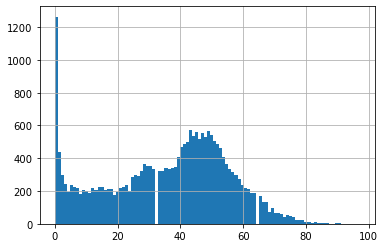

In [ ]:
track_df['popularity'].hist(bins=100)

<AxesSubplot:>

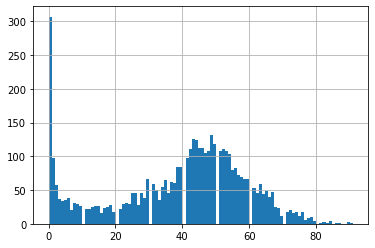

In [ ]:
# songs without preview mp3s skew slightly more popular -- surprising!
track_df[track_df['preview_url'].isna()]['popularity'].hist(bins=100)

In [48]:
# Drop tracks with null/duplicate preview mp3s
mp3s = track_df.dropna(subset=['preview_url'])
mp3s = mp3s.drop_duplicates(subset=['preview_url'])

In [49]:
mp3s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16194 entries, 0 to 22675
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            16194 non-null  object
 1   popularity    16194 non-null  int64 
 2   track         16194 non-null  object
 3   artists       16194 non-null  object
 4   album_name    16194 non-null  object
 5   album_type    16194 non-null  object
 6   release_date  16194 non-null  object
 7   image         16192 non-null  object
 8   duration_ms   16194 non-null  int64 
 9   preview_url   16194 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.4+ MB


<AxesSubplot:>

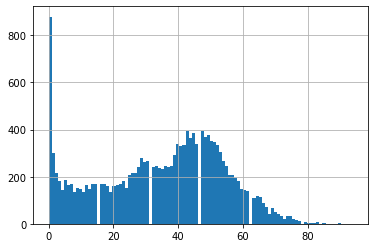

In [ ]:
# after removal of nulls/duplicate links
mp3s['popularity'].hist(bins=100)

<AxesSubplot:>

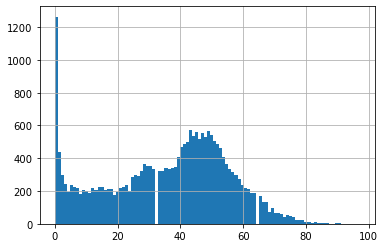

In [ ]:
# before removal of nulls/duplicate links
track_df['popularity'].hist(bins=100)

As you can see, the population distribution for songs with preview mp3s and all unique songs collected is about the same. This is despite the above thing being true about no mp3 songs, so there's no bias being introduced by the removal of songs without preview mp3s.

### Artists: examination of average popularities
Just to satisfy my curiosity, and to place popularity values into context, I looked at the distribution of mean song popularities of artists in the dataset. I used the same `track_df_expart` from above to take a look.

A lot of artists who I'd consider very popular are below 70 on average, and lot of artists I've never head of have very high average popularities...

With this in mind, above 40 seems to be a very solid line to draw for "popular". Again, I'll look at the training data only, but I expect it to have a similar distribution due to the large sample size.

In [33]:
track_df_expart.groupby('artists').mean()\
.sort_values('popularity',ascending=False)['popularity'].head(60)

artists
Julieta Venegas            92.000000
Christian Nodal            84.000000
Aventura                   80.000000
Montez                     79.000000
Empire of the Sun          79.000000
Capella Grey               79.000000
Pajel                      78.000000
Ape Drums                  77.666667
Fana Hues                  75.000000
Tems                       74.250000
Vintage Culture            74.000000
Morat                      74.000000
Slow Motion                74.000000
Bresh                      74.000000
Calibre 50                 73.000000
Maggie Lindemann           73.000000
Changbin of Stray Kids     73.000000
Omah Lay                   73.000000
F.HERO                     73.000000
CORPSE                     73.000000
Ptazeta                    72.500000
Maria Becerra              72.500000
Kellin Quinn               72.000000
Amorphous                  72.000000
Koomz                      72.000000
Static Major               71.000000
Lune                       71.

In [34]:
track_df_expart.groupby('artists').mean()\
.sort_values('popularity',ascending=False)['popularity'][60:120]

artists
Cartel De Santa      67.666667
Alok                 67.500000
Diamond Pistols      67.500000
L-Gante              67.500000
Los Legendarios      67.375000
Brent Faiyaz         67.142857
Tego Calderon        67.000000
Delaossa             67.000000
Hello O'shay         67.000000
Jacuś                67.000000
Alex Banin           67.000000
Simula               67.000000
Kendo Kaponi         67.000000
Par-T-One            67.000000
Jhay Cortez          67.000000
Chris Jedi           67.000000
Teezo Touchdown      67.000000
LIT killah           66.571429
Niranjana Ramanan    66.500000
Zano                 66.500000
Leslie               66.500000
Chucky73             66.500000
Apache 207           66.400000
OBOY                 66.333333
Billy Ray Cyrus      66.333333
Dermot Kennedy       66.000000
Mauro Dembow         66.000000
Cledos               66.000000
ArrDee               66.000000
Ricky Rich           66.000000
fem.love             66.000000
DAISY WORLD          66.000000


<AxesSubplot:>

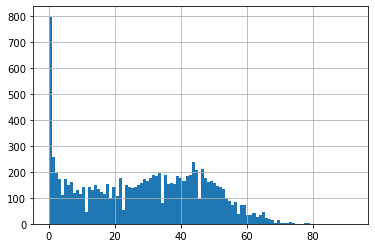

In [28]:
# a histogram of average artist popularities
# looks similar to the song popularity distribution
track_df_expart.groupby('artists').mean()\
.sort_values('popularity',ascending=False)['popularity'].hist(bins=100)

### Songs: an examination of repeat values
I saw that some songs have different mp3 preview http links but are in fact the same song, just on different albums. I'll investigate further.

In [60]:
# find duplicates based on track name and the duration
# lots of repeats -- 652 in the dataset
mp3s[mp3s.duplicated(subset=['track', 'duration_ms'], keep=False)]['track'].value_counts()

6 'N the Mornin'                                     6
3 Headed Goat (feat. Lil Baby & Polo G)              6
Zulu Screams (feat. Maleek Berry & Bibi Bourelly)    4
How TF (feat. 6LACK)                                 4
durag activity (with Travis Scott)                   4
                                                    ..
Zu Besuch                                            2
50 in Da Safe (feat. Pink Sweat$)                    2
The Announcement (Sex Drugs & Rock and Roll)         2
Shotta Flow                                          2
I'LL TAKE YOU ON (feat. Charlie Wilson)              2
Name: track, Length: 652, dtype: int64

In [61]:
# wow, this one song has 2 single entries, 2 album entries, and 2 deluxe album entries
# all with different preview mp3 links
# all of them have different popularity scores, as well!
mp3s[mp3s['track'] == "3 Headed Goat (feat. Lil Baby & Polo G)"]

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
1428,14c8arYQPMtxPcF4L4FYXC,46,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2 (Deluxe),album,2020-06-26,https://i.scdn.co/image/ab67616d0000b273fec5f2...,169531,https://p.scdn.co/mp3-preview/c9e5678e476335fb...
4297,5BSUxDJ8HcOWZD2KfExs7b,40,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2,album,2020-05-08,https://i.scdn.co/image/ab67616d0000b27390715e...,169531,https://p.scdn.co/mp3-preview/0270658a09c7cb98...
6133,6Tguhaf2uAe6OjRLsR2Tql,76,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2,album,2020-05-08,https://i.scdn.co/image/ab67616d0000b273f8558e...,169531,https://p.scdn.co/mp3-preview/6fca5999192d1a63...
14980,7J7UEZ08wc5aDsHgYpf8zI,6,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2 (Deluxe),album,2020-06-26,https://i.scdn.co/image/ab67616d0000b273bdce61...,169531,https://p.scdn.co/mp3-preview/fc4d8f65308509e2...
20285,4YEQWYhkJHgsm3Plul2FO2,28,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",3 Headed Goat (feat. Lil Baby & Polo G),single,2020-05-07,https://i.scdn.co/image/ab67616d0000b273f9e7c1...,169531,https://p.scdn.co/mp3-preview/668a0f3e8babff9a...
21203,77C9MDQMGrzKlgsUwWzr6I,28,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",3 Headed Goat (feat. Lil Baby & Polo G),single,2020-05-07,https://i.scdn.co/image/ab67616d0000b27368df4d...,169531,https://p.scdn.co/mp3-preview/4c0c14e0309ed608...


In [62]:
mp3s[mp3s.duplicated(subset=['track','duration_ms','popularity'], 
                     keep=False)]['track'].value_counts()

6 'N the Mornin'                           6
9ja Hip Hop                                3
Face Off                                   2
8 Figures                                  2
80's - Instrumental - Remastered           2
3 Headed Goat (feat. Lil Baby & Polo G)    2
Studio 54                                  2
SAME THING                                 2
One Punch Wulf                             2
50/50 Love                                 2
96 Freestyle                               2
6itch remix - feat. Nitro                  2
6565                                       2
Zero Survivors                             2
Jazz Hands                                 2
Just Mellow - Norman Cook 7'' Remix        2
Aries (feat. Peter Hook and Georgia)       2
60%                                        2
Sex Cells                                  2
Seven Day Hustle                           2
Ring (feat. Young Thug)                    2
8 Missed Calls                             2
Name: trac

Although there are duplicate songs from different albums (single, album, etc.), they often have different popularity scores, which is still valuable info. I'll keep the repeats so long as their popularity scores are different.

In [63]:
mp3s.shape

(16194, 10)

In [64]:
mp3s.drop_duplicates(subset=['track','duration_ms','popularity'], inplace=True)
mp3s.shape

(16168, 10)

In [65]:
# saving the final DataFrame as a csv
mp3s.to_csv('data/collection_1_mp3s.csv')

## Target & Librosa Processing
Now that I have my extracted dataset, I need to process my target into a binary encoded variable, and my mp3 preview links into librosa mel spectrograms before I can pass both into a neural network.

Mel spectrograms are a well-known tool to represent audio data in a visual format. It decomposes audio into frequencies and displays the frequency distributions over time. In this way, patterns regarding beat, timbre, etc. can be inferred by a model.

In [ ]:
# making train test holdout splits

X = mp3s.drop(columns=['popularity'])
y = mp3s['popularity']

X_pretr, X_holdout, y_pretr, y_holdout = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_pretr, y_pretr, 
                                                    test_size=15/90, random_state=42)
print(X_train.shape, X_test.shape, X_holdout.shape)

(12125, 9) (2426, 9) (1617, 9)


<AxesSubplot:>

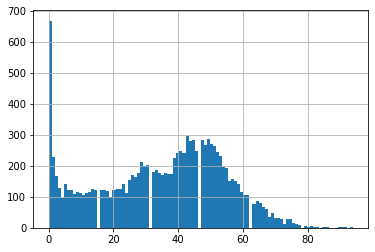

In [ ]:
# 39 seems to be a good cutoff
y_train.hist(bins=100)

In [ ]:
# defining popular as >= 39 and encoding (1 = popular)
y_train = y_train.map(lambda x: 1 if x >= 39 else 0)
y_train.value_counts(normalize=True)

0    0.512
1    0.488
Name: popularity, dtype: float64

In [ ]:
y_test = y_test.map(lambda x: 1 if x >= 39 else 0)
y_test.value_counts(normalize=True)

0    0.516076
1    0.483924
Name: popularity, dtype: float64

In [ ]:
y_holdout = y_holdout.map(lambda x: 1 if x >= 39 else 0)
y_holdout.value_counts(normalize=True)

0    0.506494
1    0.493506
Name: popularity, dtype: float64

In [ ]:
def acquire_mp3(http, directory, name):
    '''
    Acquires mp3 from an http link. Signals acquisition or timeout with a print statement.
    
    Arguments:
    http - string
        http link to the mp3 file
    directory - string
        directory within which to store the mp3
    name - string
        name for the mp3. Function adds '.mp3' to the end
        
    Returns:
    None
    '''
    try:
        r = requests.get(http, timeout=2)
        with open(f'{directory}/{name}.mp3', 'wb') as f:
            f.write(r.content)
        print(f'mp3 acquision: {name}.mp3')
    except:
        print(f'mp3 timeout: index {name}')

In [ ]:
class AudioFileGathering:
    '''
    Handle acquisition and basic processing of preview mp3 http links from Spotify API.
    '''
    def __init__(self, split, data, target):
        '''
        Initialize the acquision.
        
        Arguments:
        split - string
            Split of the data to be used: i.e. X_train, X_test, X_holdout
        data - DataFrame
            Data for the named split
        target - Series
            Target series for the split
        
        Attributes:
        data_ - DataFrame
            Copy of the passed in data
        target_ - Series
            Copy of the passed in target
        directory_ - string
            Absolute path to the directory for the split. Note: if directory does not exist,
            it is created
        mp3_directory_ - string
            Absolute path to the mp3 sub-directory for the split
        wav_directory_ - string            
            Absolute path to the wav sub-directory for the split        
        '''
        self.data_ = data.copy()
        self.target_ = target.copy()
        wd = !pwd
        self.directory_ = f'{wd[0]}/data/{split}'
        if not os.path.exists(self.directory_):
            os.mkdir(self.directory_)
        self.mp3_directory_ = f'{self.directory_}/mp3'
        self.wav_directory_ = f'{self.directory_}/wav'

    def get_mp3(self):
        '''
        Creates mp3 directory (from attribute mp3_directory_ path) if it doesn't exist.
        Calls acquire_mp3 function to acquire mp3 files from the http links in data_.
        Prints completion status.
        
        Arguments:
        None
        
        Returns:
        None
        '''
        if not os.path.exists(self.mp3_directory_):
            os.mkdir(self.mp3_directory_)
        self.data_['preview_url'].reset_index().apply(lambda x: acquire_mp3(x[1],
                                                                         self.mp3_directory_,
                                                                         x[0]), axis=1)
        print('mp3s acquired')
        
    def get_wav(self):
        '''
        Creates wav directory (from attribute wav_directory_ path) if it doesn't exist.
        Iterates through mp3_directory_, converts mp3 to wav, saves in wav_directory_.
        Creates new column in data_, `file_path`, to hold a string that is the wav filepath.
        Examines data_['file_path'] for null values. If null, drops the entry from data_ and
        target_.
        Makes a copy of 'file_path' and stores as an attribute, wav_.
        
        Attributes:
        wav_ - Series of strings
            Filepaths for the wav files for each song index
        
        Arguments:
        None
        
        Returns:
        None
        '''
        if not os.path.exists(self.wav_directory_):
            os.mkdir(self.wav_directory_)
        for file in os.listdir(self.mp3_directory_):
            src = f'{self.mp3_directory_}/{file}'
            dest = f'{self.wav_directory_}/{file.split(".")[0]}.wav'
            AudioSegment.from_mp3(src).export(dest, format='wav')
            self.data_.loc[int(file.split(".")[0]),
                            'file_path'] = dest
        for index in self.data_.index:
            if pd.isnull(self.data_['file_path'].loc[index]):
                self.target_.drop(index, inplace=True)
                self.data_.drop(index, inplace=True)
                print(f'NaN wav: index {index}')
        self.wav_ = self.data_['file_path'].copy()

In [ ]:
class LibrosaProcessing:
    '''
    Handles Libross processing tasks. In particular, mel spectrogram generation.
    '''
    def __init__(self, split)
        for 
    
    def get_wav_path(self):
        '''

        
        Arguments:
        
        Returns:
        '''
        for file in os.listdir(self.wav_directory_):
            self.data_.loc[int(file.split(".")[0]),
                            'file_path'] = f'{self.wav_directory_}/{file}'
        for index in self.data_.index:
            if pd.isnull(self.data_['file_path'].loc[index]):
                self.target_.drop(index, inplace=True)
                self.data_.drop(index, inplace=True)
                print(f'NaN wav: index {index}')
        self.wav_ = self.data_['file_path'].copy()

    def get_mel_spec(self):
        '''

        
        Arguments:
        
        Returns:
        '''
        self.specs_pre_ = []
        self.spaxmax1_ = 128 # max size in dimension 1 for X_train
        self.spaxmax2_ = 1292 # max size in dimension 2 for X_train
        for count, song in enumerate(self.wav_, start=1):
            y, sr = librosa.load(song, duration=30)
            spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y,sr=sr), ref=np.min)
            self.specs_pre_.append(spec[np.newaxis, ..., np.newaxis])
            print(f"wavs run: {count}/{len(self.wav_)}")
        resized = []
        for spec in self.specs_pre_:
            resized.append(np.resize(spec, (1, self.spaxmax1_, self.spaxmax2_, 1)))
        self.mel_specs_ = np.concatenate(resized, axis=0)
        return (self.mel_specs_, self.target_)
    
    def get_mfcc(self):
        pass
#         librosa.        
#         return 

In [ ]:
# dictionary to hold the splits and data
raw_datadict = {'X_train': (X_train, y_train), 
            'X_test': (X_test, y_test),
            'X_holdout': (X_holdout, y_holdout)}

In [ ]:
for split, info in raw_datadict.items():
    if split == 'X_train':
        continue
#         lp = LibrosaProcessing(split, info[0], info[1])
#         lp.get_mp3()
#         lp.get_wav()
#         mel_spec_datadict[split] = lp.get_mel_spec()
    if split == 'X_test':
        continue
#         lp2 = LibrosaProcessing(split, info[0], info[1])
#         lp2.get_mp3()
#         lp2.get_wav()
#         mel_spec_datadict[split] = lp2.get_mel_spec()
    if split == 'X_holdout':
        continue
#         lp3 = LibrosaProcessing(split, info[0], info[1])
#         lp3.get_mp3()
#         lp3.get_wav()
#         mel_spec_datadict[split] = lp3.get_mel_spec()

mp3 acquision: 1385.mp3
mp3 acquision: 10469.mp3
mp3 acquision: 9740.mp3
mp3 acquision: 350.mp3
mp3 acquision: 21206.mp3
mp3 acquision: 556.mp3
mp3 acquision: 14554.mp3
mp3 acquision: 5161.mp3
mp3 acquision: 12530.mp3
mp3 acquision: 6688.mp3
mp3 acquision: 8762.mp3
mp3 acquision: 10961.mp3
mp3 acquision: 20455.mp3
mp3 acquision: 12748.mp3
mp3 acquision: 11218.mp3
mp3 acquision: 21422.mp3
mp3 acquision: 5204.mp3
mp3 acquision: 3401.mp3
mp3 acquision: 21309.mp3
mp3 acquision: 6891.mp3
mp3 acquision: 933.mp3
mp3 acquision: 15721.mp3
mp3 acquision: 8794.mp3
mp3 acquision: 5136.mp3
mp3 acquision: 1453.mp3
mp3 acquision: 19207.mp3
mp3 acquision: 1773.mp3
mp3 acquision: 14165.mp3
mp3 acquision: 3063.mp3
mp3 acquision: 18950.mp3
mp3 acquision: 20408.mp3
mp3 acquision: 4303.mp3
mp3 acquision: 4957.mp3
mp3 acquision: 1785.mp3
mp3 acquision: 4772.mp3
mp3 acquision: 16081.mp3
mp3 acquision: 16242.mp3
mp3 acquision: 3265.mp3
mp3 acquision: 6704.mp3
mp3 acquision: 17841.mp3
mp3 acquision: 1103.mp3
m

mp3 acquision: 13586.mp3
mp3 acquision: 11745.mp3
mp3 acquision: 11737.mp3
mp3 acquision: 12254.mp3
mp3 acquision: 12448.mp3
mp3 acquision: 16731.mp3
mp3 acquision: 14538.mp3
mp3 acquision: 4165.mp3
mp3 acquision: 4577.mp3
mp3 acquision: 20087.mp3
mp3 acquision: 12968.mp3
mp3 acquision: 4818.mp3
mp3 acquision: 5479.mp3
mp3 acquision: 6635.mp3
mp3 acquision: 9338.mp3
mp3 acquision: 1339.mp3
mp3 acquision: 19088.mp3
mp3 acquision: 8811.mp3
mp3 acquision: 20989.mp3
mp3 acquision: 19123.mp3
mp3 acquision: 11658.mp3
mp3 acquision: 17796.mp3
mp3 acquision: 15742.mp3
mp3 acquision: 231.mp3
mp3 acquision: 9895.mp3
mp3 acquision: 16902.mp3
mp3 acquision: 3071.mp3
mp3 acquision: 3049.mp3
mp3 acquision: 12302.mp3
mp3 acquision: 14964.mp3
mp3 acquision: 10119.mp3
mp3 acquision: 4510.mp3
mp3 acquision: 2561.mp3
mp3 acquision: 7597.mp3
mp3 acquision: 13166.mp3
mp3 acquision: 3346.mp3
mp3 acquision: 13919.mp3
mp3 acquision: 11933.mp3
mp3 acquision: 11539.mp3
mp3 acquision: 20690.mp3
mp3 acquision: 15

mp3 acquision: 2966.mp3
mp3 acquision: 4115.mp3
mp3 acquision: 8442.mp3
mp3 acquision: 1716.mp3
mp3 acquision: 2943.mp3
mp3 acquision: 3092.mp3
mp3 acquision: 19871.mp3
mp3 acquision: 17544.mp3
mp3 acquision: 9615.mp3
mp3 acquision: 4847.mp3
mp3 acquision: 508.mp3
mp3 acquision: 20241.mp3
mp3 acquision: 14393.mp3
mp3 acquision: 10857.mp3
mp3 acquision: 20339.mp3
mp3 acquision: 2386.mp3
mp3 acquision: 6087.mp3
mp3 acquision: 10674.mp3
mp3 acquision: 3828.mp3
mp3 acquision: 15012.mp3
mp3 acquision: 12634.mp3
mp3 acquision: 16581.mp3
mp3 acquision: 18251.mp3
mp3 acquision: 16710.mp3
mp3 acquision: 5397.mp3
mp3 acquision: 207.mp3
mp3 acquision: 5251.mp3
mp3 acquision: 17353.mp3
mp3 acquision: 20201.mp3
mp3 acquision: 15346.mp3
mp3 acquision: 510.mp3
mp3 acquision: 4318.mp3
mp3 acquision: 19284.mp3
mp3 acquision: 15946.mp3
mp3 acquision: 2483.mp3
mp3 acquision: 2163.mp3
mp3 acquision: 13633.mp3
mp3 acquision: 17731.mp3
mp3 acquision: 834.mp3
mp3 acquision: 21209.mp3
mp3 acquision: 2230.mp3


mp3 acquision: 19126.mp3
mp3 acquision: 1137.mp3
mp3 acquision: 719.mp3
mp3 acquision: 14826.mp3
mp3 acquision: 6659.mp3
mp3 acquision: 1844.mp3
mp3 acquision: 6196.mp3
mp3 acquision: 2753.mp3
mp3 acquision: 5875.mp3
mp3 acquision: 10154.mp3
mp3 acquision: 1943.mp3
mp3 acquision: 17062.mp3
mp3 acquision: 13852.mp3
mp3 acquision: 15286.mp3
mp3 acquision: 1824.mp3
mp3 acquision: 17604.mp3
mp3 acquision: 18473.mp3
mp3 acquision: 19767.mp3
mp3 acquision: 7669.mp3
mp3 acquision: 18387.mp3
mp3 acquision: 18947.mp3
mp3 acquision: 2839.mp3
mp3 acquision: 7476.mp3
mp3 acquision: 12553.mp3
mp3 acquision: 9985.mp3
mp3 acquision: 18948.mp3
mp3 acquision: 2529.mp3
mp3 acquision: 21424.mp3
mp3 acquision: 6575.mp3
mp3 acquision: 21061.mp3
mp3 acquision: 11208.mp3
mp3 acquision: 10376.mp3
mp3 acquision: 1164.mp3
mp3 acquision: 21200.mp3
mp3 acquision: 15276.mp3
mp3 acquision: 10152.mp3
mp3 acquision: 536.mp3
mp3 acquision: 10288.mp3
mp3 acquision: 20103.mp3
mp3 acquision: 11777.mp3
mp3 acquision: 533.

mp3 acquision: 9931.mp3
mp3 acquision: 7302.mp3
mp3 acquision: 7428.mp3
mp3 acquision: 2055.mp3
mp3 acquision: 19075.mp3
mp3 acquision: 20514.mp3
mp3 acquision: 19452.mp3
mp3 acquision: 1739.mp3
mp3 acquision: 1952.mp3
mp3 acquision: 10571.mp3
mp3 acquision: 4287.mp3
mp3 acquision: 6851.mp3
mp3 acquision: 21377.mp3
mp3 acquision: 11221.mp3
mp3 acquision: 13966.mp3
mp3 acquision: 12785.mp3
mp3 acquision: 12945.mp3
mp3 acquision: 11307.mp3
mp3 acquision: 10887.mp3
mp3 acquision: 16262.mp3
mp3 acquision: 5144.mp3
mp3 acquision: 18997.mp3
mp3 acquision: 19309.mp3
mp3 acquision: 10381.mp3
mp3 acquision: 18986.mp3
mp3 acquision: 12324.mp3
mp3 acquision: 17231.mp3
mp3 acquision: 9806.mp3
mp3 acquision: 3951.mp3
mp3 acquision: 7848.mp3
mp3 acquision: 9110.mp3
mp3 acquision: 10524.mp3
mp3 acquision: 21096.mp3
mp3 acquision: 7792.mp3
mp3 acquision: 19481.mp3
mp3 acquision: 6436.mp3
mp3 acquision: 54.mp3
mp3 acquision: 4655.mp3
mp3 acquision: 17022.mp3
mp3 acquision: 15494.mp3
mp3 acquision: 453.

wavs run: 79/1615
wavs run: 80/1615
wavs run: 81/1615
wavs run: 82/1615
wavs run: 83/1615
wavs run: 84/1615
wavs run: 85/1615
wavs run: 86/1615
wavs run: 87/1615
wavs run: 88/1615
wavs run: 89/1615
wavs run: 90/1615
wavs run: 91/1615
wavs run: 92/1615
wavs run: 93/1615
wavs run: 94/1615
wavs run: 95/1615
wavs run: 96/1615
wavs run: 97/1615
wavs run: 98/1615
wavs run: 99/1615
wavs run: 100/1615
wavs run: 101/1615
wavs run: 102/1615
wavs run: 103/1615
wavs run: 104/1615
wavs run: 105/1615
wavs run: 106/1615
wavs run: 107/1615
wavs run: 108/1615
wavs run: 109/1615
wavs run: 110/1615
wavs run: 111/1615
wavs run: 112/1615
wavs run: 113/1615
wavs run: 114/1615
wavs run: 115/1615
wavs run: 116/1615
wavs run: 117/1615
wavs run: 118/1615
wavs run: 119/1615
wavs run: 120/1615
wavs run: 121/1615
wavs run: 122/1615
wavs run: 123/1615
wavs run: 124/1615
wavs run: 125/1615
wavs run: 126/1615
wavs run: 127/1615
wavs run: 128/1615
wavs run: 129/1615
wavs run: 130/1615
wavs run: 131/1615
wavs run: 132/

wavs run: 512/1615
wavs run: 513/1615
wavs run: 514/1615
wavs run: 515/1615
wavs run: 516/1615
wavs run: 517/1615
wavs run: 518/1615
wavs run: 519/1615
wavs run: 520/1615
wavs run: 521/1615
wavs run: 522/1615
wavs run: 523/1615
wavs run: 524/1615
wavs run: 525/1615
wavs run: 526/1615
wavs run: 527/1615
wavs run: 528/1615
wavs run: 529/1615
wavs run: 530/1615
wavs run: 531/1615
wavs run: 532/1615
wavs run: 533/1615
wavs run: 534/1615
wavs run: 535/1615
wavs run: 536/1615
wavs run: 537/1615
wavs run: 538/1615
wavs run: 539/1615
wavs run: 540/1615
wavs run: 541/1615
wavs run: 542/1615
wavs run: 543/1615
wavs run: 544/1615
wavs run: 545/1615
wavs run: 546/1615
wavs run: 547/1615
wavs run: 548/1615
wavs run: 549/1615
wavs run: 550/1615
wavs run: 551/1615
wavs run: 552/1615
wavs run: 553/1615
wavs run: 554/1615
wavs run: 555/1615
wavs run: 556/1615
wavs run: 557/1615
wavs run: 558/1615
wavs run: 559/1615
wavs run: 560/1615
wavs run: 561/1615
wavs run: 562/1615
wavs run: 563/1615
wavs run: 56

wavs run: 944/1615
wavs run: 945/1615
wavs run: 946/1615
wavs run: 947/1615
wavs run: 948/1615
wavs run: 949/1615
wavs run: 950/1615
wavs run: 951/1615
wavs run: 952/1615
wavs run: 953/1615
wavs run: 954/1615
wavs run: 955/1615
wavs run: 956/1615
wavs run: 957/1615
wavs run: 958/1615
wavs run: 959/1615
wavs run: 960/1615
wavs run: 961/1615
wavs run: 962/1615
wavs run: 963/1615
wavs run: 964/1615
wavs run: 965/1615
wavs run: 966/1615
wavs run: 967/1615
wavs run: 968/1615
wavs run: 969/1615
wavs run: 970/1615
wavs run: 971/1615
wavs run: 972/1615
wavs run: 973/1615
wavs run: 974/1615
wavs run: 975/1615
wavs run: 976/1615
wavs run: 977/1615
wavs run: 978/1615
wavs run: 979/1615
wavs run: 980/1615
wavs run: 981/1615
wavs run: 982/1615
wavs run: 983/1615
wavs run: 984/1615
wavs run: 985/1615
wavs run: 986/1615
wavs run: 987/1615
wavs run: 988/1615
wavs run: 989/1615
wavs run: 990/1615
wavs run: 991/1615
wavs run: 992/1615
wavs run: 993/1615
wavs run: 994/1615
wavs run: 995/1615
wavs run: 99

wavs run: 1357/1615
wavs run: 1358/1615
wavs run: 1359/1615
wavs run: 1360/1615
wavs run: 1361/1615
wavs run: 1362/1615
wavs run: 1363/1615
wavs run: 1364/1615
wavs run: 1365/1615
wavs run: 1366/1615
wavs run: 1367/1615
wavs run: 1368/1615
wavs run: 1369/1615
wavs run: 1370/1615
wavs run: 1371/1615
wavs run: 1372/1615
wavs run: 1373/1615
wavs run: 1374/1615
wavs run: 1375/1615
wavs run: 1376/1615
wavs run: 1377/1615
wavs run: 1378/1615
wavs run: 1379/1615
wavs run: 1380/1615
wavs run: 1381/1615
wavs run: 1382/1615
wavs run: 1383/1615
wavs run: 1384/1615
wavs run: 1385/1615
wavs run: 1386/1615
wavs run: 1387/1615
wavs run: 1388/1615
wavs run: 1389/1615
wavs run: 1390/1615
wavs run: 1391/1615
wavs run: 1392/1615
wavs run: 1393/1615
wavs run: 1394/1615
wavs run: 1395/1615
wavs run: 1396/1615
wavs run: 1397/1615
wavs run: 1398/1615
wavs run: 1399/1615
wavs run: 1400/1615
wavs run: 1401/1615
wavs run: 1402/1615
wavs run: 1403/1615
wavs run: 1404/1615
wavs run: 1405/1615
wavs run: 1406/1615


In [ ]:
mel_spec_datadict['X_holdout'][0].shape

(1615, 128, 1292, 1)

In [ ]:
y, sr = librosa.load(lp.wav_.iloc[0],duration=30)
ipd.Audio(y,rate=sr)

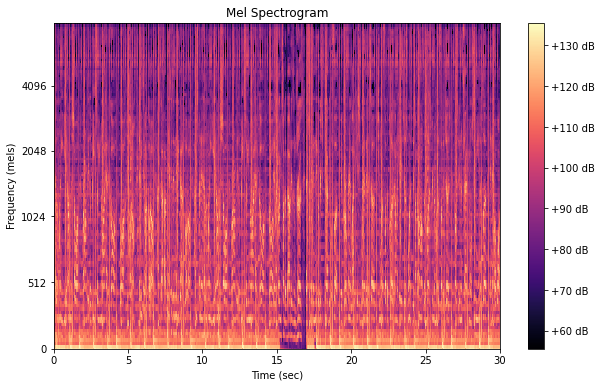

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
img = librosa.display.specshow(lp.specs_pre_[2000][0,:,:,0], x_axis='time', 
                               y_axis='mel', fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram', xlabel='Time (sec)', ylabel='Frequency (mels)');

In [ ]:
# saving the raw mel spectrograms
with open('mel_spec_dict.pkl', 'wb') as p:
    pickle.dump(mel_spec_datadict, p)

In [ ]:
class MinMaxScaler:
    '''
    Custom min-max scaler to scale a tensor of any dimension (in my case, 4D)
    '''
    def fit(self, X_train):
        '''
        Fit to the training data.
        Saves max and min as attributes.
        
        Attributes:
        max_ - float
            Maximum value of the tensor
        min_ - float
            Minimum value of the tensor        
        '''
        self.X_train_ = X_train
        self.max_ = self.X_train_.max()
        self.min_ = self.X_train_.min()
        
    def transform(self, X):
        '''
        Transform X data.
        
        Arguments:
        X - tensor
            X data split
        
        Returns:
        Scaled X data split
        '''
        return (X - self.min_) / (self.max_ - self.min_)
        

In [ ]:
# Scaling
mm = MinMaxScaler()
mm.fit(mel_spec_datadict['X_train'][0])

mel_spec_sc = {}
for split, info in mel_spec_datadict.items():
    scaledX = mm.transform(info[0])
    mel_spec_sc[split] = (scaledX, info[1])


In [ ]:
mel_spec_sc['X_test'][1].shape

(2426,)

In [ ]:
# saved scaled mel spectrograms
with open('mel_spec_sc.pkl', 'wb') as p:
    pickle.dump(mel_spec_sc, p)

## Modeling
Spectrograms are a type of image, so this workflow is similar to an image classification problem using neural networks.

I begin with a baseline understanding, then move to a traditional multi-layer perceptron. I develop the neural networks with a couple different convolutional configurations, and then finish with a Convolutional Neural Net that includes a Gated Recurrent Unit, which is a type of Recursive/Recurrent Neural Network.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed

import numpy as np
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

In [4]:
# Defining a results visualization function
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8), sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [5]:
# unpickling and separating out the necessary data
with open('/content/drive/MyDrive/Colab Notebooks/mel_spec_sc.pkl', 'rb') as up:
    mel_spec_sc = pickle.load(up)
X_train, y_train = mel_spec_sc['X_train'][0], mel_spec_sc['X_train'][1]
X_test, y_test = mel_spec_sc['X_test'][0], mel_spec_sc['X_test'][1]
X_holdout, y_holdout = mel_spec_sc['X_holdout'][0], mel_spec_sc['X_holdout'][1]

### Baseline Understanding
Eventually, I will need a sense for how a untrained/useless neural network is going to perform. I will get this information by looking at

### First Model - Multilayer Perceptron

In [6]:
input_shape = X_train.shape[1:]
batch_size = X_train.shape[0]/100

In [11]:
input_shape

(128, 1292, 1)

In [ ]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
mlp = keras.Sequential(name='mlp')

# flatten input 3D tensor to 1D
mlp.add(layers.Flatten(input_shape=input_shape))

# two hidden layers
mlp.add(layers.Dense(128, activation='relu'))
mlp.add(layers.Dense(64, activation='relu'))

# output layer
mlp.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
mlp.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
mlp.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 165376)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               21168256  
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,176,577
Trainable params: 21,176,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fsm_history = mlp.fit(X_train, y_train, epochs=60, batch_size=30,
                  validation_data=(X_test, y_test))

Epoch 1/60
346/346 [==============================] - 15s 39ms/step - loss: 2.5842 - accuracy: 0.4952 - recall: 0.4904 - val_loss: 1.5612 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 2/60
346/346 [==============================] - 14s 41ms/step - loss: 0.8632 - accuracy: 0.4939 - recall: 0.4727 - val_loss: 0.7065 - val_accuracy: 0.4885 - val_recall: 0.9991
Epoch 3/60
346/346 [==============================] - 14s 41ms/step - loss: 0.7371 - accuracy: 0.5040 - recall: 0.4894 - val_loss: 0.7026 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 4/60
346/346 [==============================] - 14s 41ms/step - loss: 0.7106 - accuracy: 0.5095 - recall: 0.4975 - val_loss: 0.6937 - val_accuracy: 0.4893 - val_recall: 0.9991
Epoch 5/60
346/346 [==============================] - 14s 41ms/step - loss: 0.7029 - accuracy: 0.4978 - recall: 0.4389 - val_loss: 0.6921 - val_accuracy: 0.5227 - val_recall: 0.9157
Epoch 6/60
346/346 [==============================] - 14s 41ms/step - loss: 0.7130

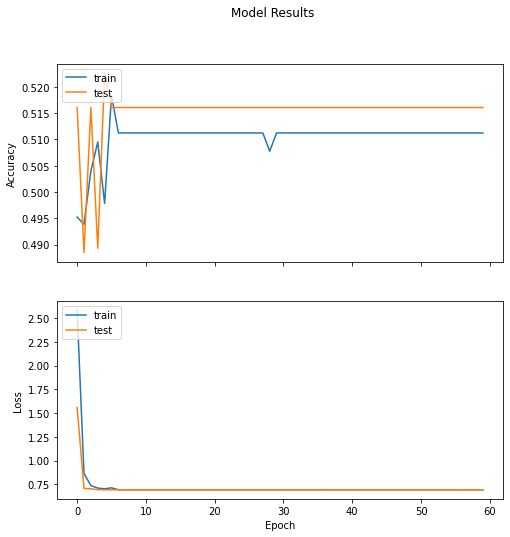

In [ ]:
visualize_training_results(fsm_history)

## CNN

In [ ]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn1 = keras.Sequential(name='cnn1')

# convolutional and max pooling layers with successively more filters
cnn1.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn1.add(layers.MaxPooling2D((2, 4)))

cnn1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn1.add(layers.MaxPooling2D((2, 4)))

cnn1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn1.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(128, activation='relu'))
cnn1.add(layers.Dropout(0.3))
cnn1.add(layers.Dense(64, activation='relu'))
cnn1.add(layers.Dropout(0.3))

# output layer
cnn1.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
cnn1.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
cnn1.summary()

Model: "cnn1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 1292, 16)     160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 323, 16)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 323, 32)       4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 80, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 40, 64)       0      

In [ ]:
cnn1_history = cnn1.fit(X_train, y_train, epochs=60, batch_size=100,
                  validation_data=(X_test, y_test))

Epoch 1/60
104/104 [==============================] - 191s 2s/step - loss: 0.6937 - accuracy: 0.5081 - recall: 0.0949 - val_loss: 0.6926 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 2/60
104/104 [==============================] - 190s 2s/step - loss: 0.6930 - accuracy: 0.5074 - recall: 0.0497 - val_loss: 0.6929 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 3/60
104/104 [==============================] - 177s 2s/step - loss: 0.6932 - accuracy: 0.5114 - recall: 0.0026 - val_loss: 0.6928 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 4/60
104/104 [==============================] - 166s 2s/step - loss: 0.6929 - accuracy: 0.5112 - recall: 7.8942e-04 - val_loss: 0.6927 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 5/60
104/104 [==============================] - 162s 2s/step - loss: 0.6930 - accuracy: 0.5112 - recall: 0.0000e+00 - val_loss: 0.6927 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 6/60
104/104 [==============================] - 162s 2s/step 

KeyboardInterrupt: ignored

In [ ]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn2 = keras.Sequential(name='cnn2')

# convolutional and max pooling layers with successively more filters
cnn2.add(layers.Conv2D(32, (2, 3), activation='relu', padding='same', input_shape=input_shape))
cnn2.add(layers.MaxPooling2D((2, 4)))

cnn2.add(layers.Conv2D(64, (2, 3), activation='relu', padding='same'))
cnn2.add(layers.MaxPooling2D((2, 4)))

cnn2.add(layers.Conv2D(128, (2, 3), activation='relu', padding='same'))
cnn2.add(layers.MaxPooling2D((2, 2)))

cnn2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn2.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(128, activation='relu'))
# cnn2.add(layers.Dropout(0.3))
# cnn2.add(layers.Dense(64, activation='relu'))
# cnn2.add(layers.Dropout(0.3))

# output layer
cnn2.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
cnn2.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
cnn2.summary()

Model: "cnn2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 1292, 32)     224       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 323, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 323, 64)       12352     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 80, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 80, 128)       49280     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 40, 128)      0      

In [ ]:
cnn2_history = cnn2.fit(X_train, y_train, epochs=60, batch_size=100,
                  validation_data=(X_test, y_test))

 51/104 [=============>................] - ETA: 1:52 - loss: 0.4188 - accuracy: 0.7971 - recall: 0.8107

KeyboardInterrupt: ignored

In [ ]:
visualize_training_results(cnn2_history)

NameError: ignored

In [1]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn3 = keras.Sequential(name='cnn3')

# convolutional and max pooling layers with successively more filters
cnn3.add(layers.Conv2D(32, (2, 3), activation='relu', padding='same', input_shape=input_shape))
cnn3.add(layers.MaxPooling2D((2, 4)))

cnn3.add(layers.Conv2D(64, (2, 3), activation='relu', padding='same'))
cnn3.add(layers.MaxPooling2D((2, 4)))

cnn3.add(layers.Conv2D(128, (2, 3), activation='relu', padding='same'))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn3.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(128, activation='relu'))
cnn3.add(layers.Dropout(0.3))
cnn3.add(layers.Dense(64, activation='relu'))
cnn3.add(layers.Dropout(0.3))

# output layer
cnn3.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
cnn3.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
cnn3.summary()

NameError: ignored

In [ ]:
cnn3_history = cnn3.fit(X_train, y_train, epochs=120, batch_size=100,
                  validation_data=(X_test, y_test))

Epoch 1/120
104/104 [==============================] - 235s 2s/step - loss: 0.6933 - accuracy: 0.5073 - recall: 0.2368 - val_loss: 0.6938 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 2/120
104/104 [==============================] - 239s 2s/step - loss: 0.6930 - accuracy: 0.5070 - recall: 0.0967 - val_loss: 0.6932 - val_accuracy: 0.4839 - val_recall: 1.0000
Epoch 3/120
104/104 [==============================] - 231s 2s/step - loss: 0.6933 - accuracy: 0.5126 - recall: 0.0857 - val_loss: 0.6928 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 4/120
104/104 [==============================] - 230s 2s/step - loss: 0.6931 - accuracy: 0.5116 - recall: 0.0020 - val_loss: 0.6927 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 5/120
104/104 [==============================] - 231s 2s/step - loss: 0.6929 - accuracy: 0.5115 - recall: 0.0022 - val_loss: 0.6927 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 6/120
104/104 [==============================] - 233s 2s/step - loss

In [8]:
visualize_training_results(cnn3_history)

NameError: ignored

## RNN

In [23]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
rnn = keras.Sequential(name='rnn')

# convolutional and max pooling layers with successively more filters
rnn.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same', input_shape=(128, 1292, 1)))
rnn.add(layers.MaxPooling2D((2, 2)))
rnn.add(layers.Dropout(0.1))

rnn.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
rnn.add(layers.MaxPooling2D((4, 2)))
rnn.add(layers.Dropout(0.1))

rnn.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
rnn.add(layers.MaxPooling2D((4, 2)))
rnn.add(layers.Dropout(0.1))

rnn.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
rnn.add(layers.MaxPool2D((4, 2)))
rnn.add(layers.Dropout(0.1))

rnn.add(layers.Reshape((80,128)))
rnn.add(layers.GRU(units=32, dropout=0.3, return_sequences=True))
rnn.add(layers.GRU(units=32, dropout=0.3))

# output layer
rnn.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
rnn.compile(loss='binary_crossentropy',
            optimizer="adam", 
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
rnn.summary()

Model: "rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 128, 1292, 64)     640       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 64, 646, 64)      0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 64, 646, 64)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 646, 128)      73856     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 323, 128)     0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 16, 323, 128)      0       

In [ ]:
rnn_history = rnn.fit(X_train, y_train, epochs=100, batch_size=100,
                  validation_data=(X_test, y_test))

Epoch 1/100
104/104 [==============================] - 1023s 10s/step - loss: 0.6970 - accuracy: 0.5051 - recall: 0.3734 - val_loss: 0.6913 - val_accuracy: 0.5223 - val_recall: 0.2223
Epoch 2/100
104/104 [==============================] - 991s 10s/step - loss: 0.6932 - accuracy: 0.5156 - recall: 0.3278 - val_loss: 0.6940 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 3/100
104/104 [==============================] - 997s 10s/step - loss: 0.6932 - accuracy: 0.5153 - recall: 0.3233 - val_loss: 0.6908 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 4/100
104/104 [==============================] - 998s 10s/step - loss: 0.6906 - accuracy: 0.5260 - recall: 0.4703 - val_loss: 0.6883 - val_accuracy: 0.5289 - val_recall: 0.5945
Epoch 5/100
104/104 [==============================] - 1022s 10s/step - loss: 0.6881 - accuracy: 0.5328 - recall: 0.4604 - val_loss: 0.6876 - val_accuracy: 0.5317 - val_recall: 0.0792
Epoch 6/100
104/104 [==============================] - 983s 9s/step - loss:

In [1]:
 visualize_training_results(rnn_history)

NameError: ignored

## Conclusion

Did not use LIME, but will investigate moving forward